In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Models used for classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Ohter libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTENC

import warnings
warnings.filterwarnings("ignore")

In [285]:
df = pd.read_csv('../Datasets/stoke_prediction.csv')

In [286]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
5,32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,NaN,0
6,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
9,28674,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [288]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

<AxesSubplot:xlabel='stroke', ylabel='count'>

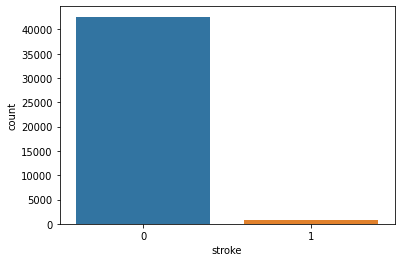

In [289]:
sns.countplot(data = df, x = 'stroke')

In [290]:
for col in df.columns:
    if df[col].dtype == 'O':
        print(col, df[col].unique())

gender ['Male' 'Female' 'Other']
ever_married ['No' 'Yes']
work_type ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Residence_type ['Rural' 'Urban']
smoking_status [nan 'never smoked' 'formerly smoked' 'smokes']


There are null values present in two columns, bmi and smoking status. There are two possible ways to deal with it, either drop it or fill it with some average value. <br> Depending on how much null value is present in people who had stroke, we will decide whether to drop it or not.

In [291]:
df.corr().style.background_gradient(cmap='viridis')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.012760,0.006571,0.009234,0.024634,0.018839,0.002976
age,0.012760,1.000000,0.272169,0.250188,0.237627,0.358897,0.156049
hypertension,0.006571,0.272169,1.000000,0.119777,0.160211,0.161225,0.075332
heart_disease,0.009234,0.250188,0.119777,1.000000,0.146938,0.057677,0.113763
avg_glucose_level,0.024634,0.237627,0.160211,0.146938,1.000000,0.191295,0.078917
bmi,0.018839,0.358897,0.161225,0.057677,0.191295,1.000000,0.020285
stroke,0.002976,0.156049,0.075332,0.113763,0.078917,0.020285,1.000000


<AxesSubplot:xlabel='smoking_status', ylabel='count'>

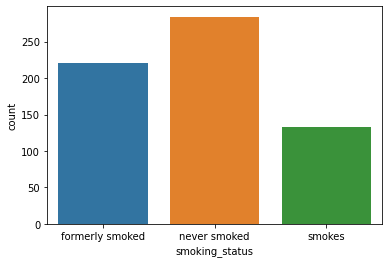

In [292]:
sns.countplot(data = df[df['stroke'] == 1], x = 'smoking_status')

In [293]:
df.gender.value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [294]:
df = df[df.gender != 'Other']

In [295]:
df[df['stroke'] == 1].isna().sum()/len(df[df['stroke'] == 1])*100

id                    0.000000
gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                  17.879949
smoking_status       18.518519
stroke                0.000000
dtype: float64

So, almost 18% of people that had stroke has missing values. We are going to drop missing values.

In [296]:
'''
def train_imputation(dataset, fill_type = 'drop'):

    if fill_type == 'drop':
        dataset.dropna(axis = 0, inplace = True)

    if fill_type == 'mode':
        imputation = SimpleImputer(strategy = 'most_frequent')
'''

"\ndef train_imputation(dataset, fill_type = 'drop'):\n\n    if fill_type == 'drop':\n        dataset.dropna(axis = 0, inplace = True)\n\n    if fill_type == 'mode':\n        imputation = SimpleImputer(strategy = 'most_frequent')\n"

In [297]:
df.dropna(axis = 0, inplace = True)

In [298]:
df.drop(['id'], axis = 1, inplace = True)

In [299]:
df['stroke'].value_counts()

0    28517
1      548
Name: stroke, dtype: int64

In [300]:
cat_col = [col for col in df.columns if df[col].dtype == 'O']
ohe = OneHotEncoder(sparse = False)

def one_hot(X_train, X_test, encode = ohe, cat_col = cat_col):

    oh_train = pd.DataFrame(encode.fit_transform(X_train[cat_col]))
    oh_train.index = X_train.index
    oh_train.columns = np.concatenate(encode.categories_)
    X_train = X_train.drop(cat_col, axis = 1)
    X_train  = pd.concat([X_train , oh_train], axis = 1)

    oh_test = pd.DataFrame(encode.transform(X_test[cat_col]))
    oh_test.index = X_test.index
    oh_test.columns = np.concatenate(encode.categories_)
    X_test = X_test.drop(cat_col, axis = 1)
    X_test  = pd.concat([X_test, oh_test], axis = 1)

    X_train.drop(['Male', 'No', 'children', 'Rural', 'formerly smoked'], axis = 1, inplace = True)
    X_test.drop(['Female', 'No', 'children', 'Rural', 'formerly smoked'], axis = 1, inplace = True)

    return X_train, X_test

In [301]:
scale_cols = ['age', 'avg_glucose_level', 'bmi']
scale_transform = MinMaxScaler()

def scaler(X_train, X_test, encode = scale_transform, scale_cols = scale_cols):
    scaled = encode.fit_transform(X_train[scale_cols])
    scaled = pd.DataFrame(scaled, columns = scale_cols)
    scaled.index = X_train.index
    X_train[scale_cols] = scaled

    scaled = encode.transform(X_test[scale_cols])
    scaled = pd.DataFrame(scaled, columns = scale_cols)
    scaled.index = X_test.index
    scaled.head()
    X_test[scale_cols] = scaled

    return X_train, X_test

In [302]:
X = df.drop(['stroke'], axis = 1)
y = df['stroke']

### Model preparation

In [303]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
xgbc = XGBClassifier()

In [304]:
def training(X_train, y_train, X_test):
    models = {'LogisticRegression': lr, 'KNeighbors': knn, 'XGBoost':xgbc}
    preds = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print('{}, done.'.format(name))
        preds[name] = pred

    return preds

In [305]:
def classify(y, preds):
    classifcations = {}

    for name, pred in preds.items():
        classifcation = classification_report(y, pred)
        classifcations[name] = classifcation
            
    return classifcations 

## Modelling without dealing with unbalanced data

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [307]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
35895,Male,64.0,1,0,Yes,Govt_job,Urban,227.58,48.6,never smoked
30251,Male,79.0,0,1,Yes,Private,Rural,246.58,28.5,formerly smoked
6563,Male,30.0,0,0,No,Private,Rural,94.46,31.1,formerly smoked
33163,Female,64.0,0,0,Yes,Private,Rural,83.84,20.7,never smoked
47,Female,66.0,0,0,Yes,Private,Rural,141.24,28.5,never smoked


In [308]:
X_train, X_test = one_hot(X_train, X_test)
X_train, X_test = scaler(X_train, X_test)

In [309]:
X_train.sample(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,Female,Yes,Govt_job,Never_worked,Private,Self-employed,Urban,never smoked,smokes
3349,0.138889,0,0,0.123115,0.213675,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
28068,0.486111,0,0,0.156287,0.255189,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33420,0.319444,0,0,0.067150,0.120879,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
30245,0.305556,0,0,0.172174,0.279609,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32966,0.277778,0,0,0.298255,0.273504,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
27227,0.597222,0,0,0.072657,0.410256,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
12518,0.583333,1,0,0.178105,0.252747,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
36827,0.486111,0,0,0.069226,0.184371,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3851,0.444444,0,0,0.269192,0.440781,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15121,0.472222,0,0,0.157389,0.330891,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [310]:
preds = training(X_train, y_train, X_test)
class_score = classify(y_test, preds)

LogisticRegression, done.
KNeighbors, done.
XGBoost, done.


In [311]:
print(class_score['LogisticRegression'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5713
           1       0.00      0.00      0.00       100

    accuracy                           0.98      5813
   macro avg       0.49      0.50      0.50      5813
weighted avg       0.97      0.98      0.97      5813



In [312]:
print(class_score['KNeighbors'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5713
           1       0.00      0.00      0.00       100

    accuracy                           0.98      5813
   macro avg       0.49      0.50      0.50      5813
weighted avg       0.97      0.98      0.97      5813



In [313]:
print(class_score['XGBoost'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5713
           1       0.00      0.00      0.00       100

    accuracy                           0.98      5813
   macro avg       0.49      0.50      0.50      5813
weighted avg       0.97      0.98      0.97      5813



As expected, results from all three models shows worse performance when checking the precision and recall, especially logistic and knn where precision and recall of person having stroke went to 0. So, we are going to apply different methods to deal with unbalanced data.
1. Undersampling
2. Oversampling

### Undersampling

In [314]:
rusm = RandomUnderSampler(random_state = 42)
X_res, y_res = rusm.fit_resample(X, y)

#nm = NearMiss(version = 1, n_neighbors = 3)
#X_train, y_train = nm.fit_resample(X_train, y_train)
#X_test, y_test = nm.fit_resample(X_test, y_test)

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

X_train, X_test = one_hot(X_train, X_test)
X_train, X_test = scaler(X_train, X_test)

preds = training(X_train, y_train, X_test)
class_score = classify(y_test, preds)

LogisticRegression, done.
KNeighbors, done.
XGBoost, done.


In [318]:
print(class_score['LogisticRegression'])

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       113
           1       0.74      0.80      0.77       107

    accuracy                           0.77       220
   macro avg       0.77      0.77      0.77       220
weighted avg       0.77      0.77      0.77       220



In [319]:
print(class_score['KNeighbors'])

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       113
           1       0.68      0.76      0.72       107

    accuracy                           0.71       220
   macro avg       0.71      0.71      0.71       220
weighted avg       0.71      0.71      0.71       220



In [320]:
print(class_score['XGBoost'])

              precision    recall  f1-score   support

           0       0.75      0.63      0.68       113
           1       0.66      0.78      0.72       107

    accuracy                           0.70       220
   macro avg       0.71      0.70      0.70       220
weighted avg       0.71      0.70      0.70       220



When undersampling, results related to people not having stroke dropped from 99% to an average of 75%, but on the other hand results related to people having stroke has increased significantly.

### Oversampling

In [329]:
rosm = RandomOverSampler(random_state = 42)
X_res, y_res = rosm.fit_resample(X, y)

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

X_train, X_test = one_hot(X_train, X_test)
X_train, X_test = scaler(X_train, X_test)

preds = training(X_train, y_train, X_test)
class_score = classify(y_test, preds)

LogisticRegression, done.
KNeighbors, done.
XGBoost, done.


In [331]:
print(class_score['LogisticRegression'])

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      5617
           1       0.74      0.79      0.77      5790

    accuracy                           0.76     11407
   macro avg       0.76      0.76      0.76     11407
weighted avg       0.76      0.76      0.76     11407



In [332]:
print(class_score['KNeighbors'])

              precision    recall  f1-score   support

           0       0.54      0.94      0.68      5617
           1       0.78      0.21      0.34      5790

    accuracy                           0.57     11407
   macro avg       0.66      0.58      0.51     11407
weighted avg       0.66      0.57      0.51     11407



In [333]:
print(class_score['XGBoost'])

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5617
           1       0.94      0.99      0.96      5790

    accuracy                           0.96     11407
   macro avg       0.96      0.96      0.96     11407
weighted avg       0.96      0.96      0.96     11407



As we can see, oversampling has improved performance a lot. The most significant improvement is seen on XGBoost. Models like Logistic Regression has performed similar in undersampling and oversampling while K Neighbors Classifiers results worsens due to the presence of noise in the data due to oversampling. 